In [ ]:
import os

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import torchvision as tv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
DATA_DIR = '/kaggle/input/anime-faces'

In [ ]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize(64),
    tv.transforms.CenterCrop(64),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=transforms)

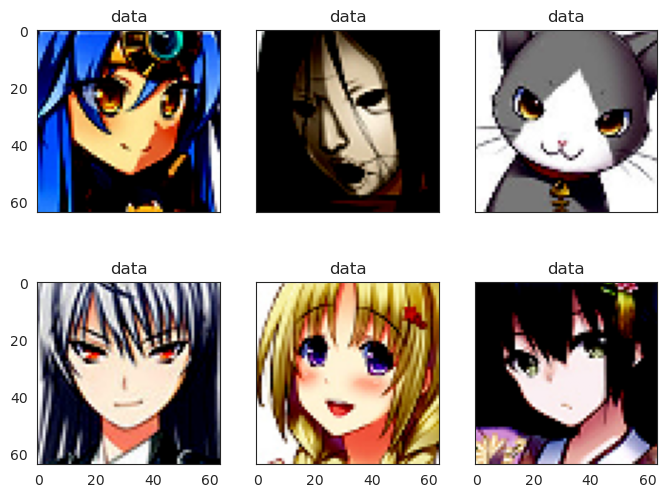

In [ ]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

show_images(train_ds)

In [ ]:
dev = "cuda" if torch.cuda.is_available() else "cpu"
dev

'cuda'

In [ ]:
batch_size = 128
z_dim = 100

In [ ]:
train = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True
)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.conv_blocks(z)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, img):
        out =  self.model(img)
        return out

In [ ]:
G = Generator().to(dev)
D = Discriminator().to(dev)

In [ ]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [ ]:
BATCH_SIZE = 128

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.to(dev), torch.ones(BATCH_SIZE, 1).to(dev)

    D_output = D(x_real)

    D_real_loss = criterion(D_output.to(dev), y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = torch.randn(batch_size, z_dim, 1, 1, device=dev)
    x_fake = G(z)
    y_fake = torch.zeros(x_fake.size(0), 1, device=dev)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output.to(dev), y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn(batch_size, z_dim, 1, 1, device=dev)
    y = torch.ones(batch_size, 1, device=dev)

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [ ]:
n_epoch = 50
for epoch in range(1, n_epoch+1):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train):
        if len(x) != BATCH_SIZE:
          continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/50]: loss_d: 0.199, loss_g: 6.514
[2/50]: loss_d: 0.054, loss_g: 9.095
[3/50]: loss_d: 0.036, loss_g: 10.026
[4/50]: loss_d: 0.042, loss_g: 11.164
[5/50]: loss_d: 0.037, loss_g: 10.689
[6/50]: loss_d: 0.042, loss_g: 11.937
[7/50]: loss_d: 0.039, loss_g: 11.948
[8/50]: loss_d: 0.035, loss_g: 12.633
[9/50]: loss_d: 0.048, loss_g: 12.856
[10/50]: loss_d: 0.048, loss_g: 11.136
[11/50]: loss_d: 0.045, loss_g: 11.544
[12/50]: loss_d: 0.039, loss_g: 11.736
[13/50]: loss_d: 0.056, loss_g: 12.295
[14/50]: loss_d: 0.050, loss_g: 12.188
[15/50]: loss_d: 0.043, loss_g: 11.862
[16/50]: loss_d: 0.044, loss_g: 11.361
[17/50]: loss_d: 0.046, loss_g: 11.521
[18/50]: loss_d: 0.048, loss_g: 11.958
[19/50]: loss_d: 0.046, loss_g: 10.952
[20/50]: loss_d: 0.043, loss_g: 11.349
[21/50]: loss_d: 0.050, loss_g: 11.553
[22/50]: loss_d: 0.040, loss_g: 11.216
[23/50]: loss_d: 0.043, loss_g: 11.824
[24/50]: loss_d: 0.038, loss_g: 11.584
[25/50]: loss_d: 0.041, loss_g: 11.852
[26/50]: loss_d: 0.038, loss_g: 11.9

In [ ]:
test = torch.randn(batch_size, z_dim, 1, 1, device=dev)
gen = G(test)
gen.shape

torch.Size([128, 3, 64, 64])

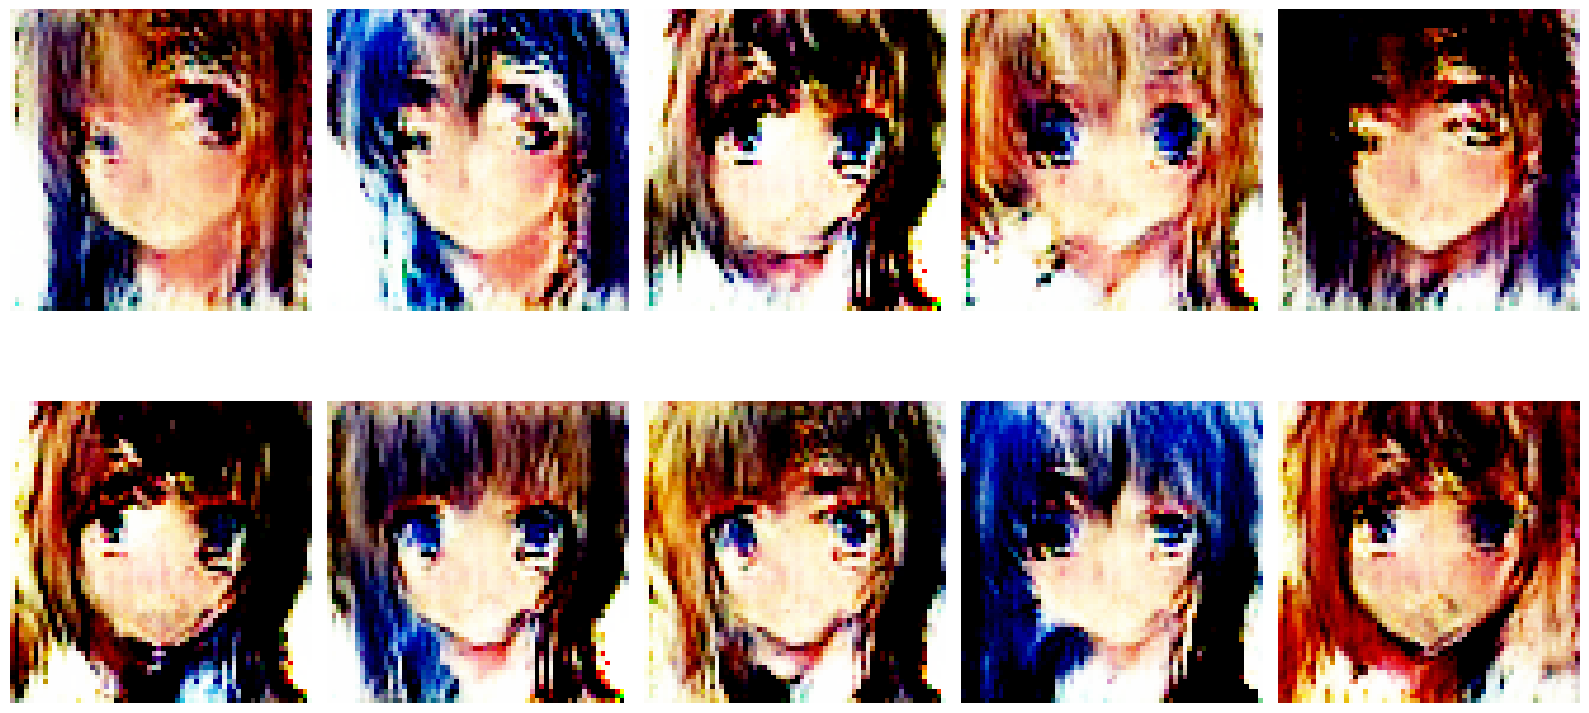

In [ ]:
plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(2):
    plt.subplot(2, 5, y * 5 + x + 1)
    plt.axis('off')
    plt.imshow(gen[y * 5 + x].permute(1,2,0).detach().cpu(), cmap='gray')
plt.tight_layout()
plt.show()